# Importing Data

Daily closing stock prices of Apple Inc. (AAPL) obtained from Yahoo Finance\footnote{\url{https://finance.yahoo.com}}

In [ ]:
import yfinance as yf
import pandas as pd

# ---------------Download AAPL(Apple Inc.) data with adjusted prices-------------------------
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01", auto_adjust=True)

#---------------------------- Extract the Close price-----------------------
#The full Yahoo Finance dataset data includes multiple columns: Open, High, Low, Close, Volume
#The line data[['Close']] selects only the "Close" price column
close_prices = data[['Close']].copy()

#------------------Forward-fill missing values----------------------
#If any value in the "Close" column is missing (NaN), this method fills it with the previous day's value.
close_prices.ffill(inplace=True)

# Save to CSV
close_prices.to_csv("AAPL_Close_2015_2022.csv")

print(close_prices.head())



# Data Preprocessing

AAPL Stock Price Data Preprocessing

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# ----------- Download and clean AAPL Close price data ------------------
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01", auto_adjust=True)
close_prices = data[['Close']].copy()
close_prices.ffill(inplace=True)

# ----------- Normalize to [0, 1] using Min-Max scaling ------------------
scaler = MinMaxScaler()
close_prices['Close_scaled'] = scaler.fit_transform(close_prices[['Close']])

# ----------- Create sliding window sequences ------------------
def create_sequences(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

X_stock, y_stock = create_sequences(close_prices['Close_scaled'].values, window_size=30)

# ----------- Split into train (70%), val (15%), test (15%) ---------------
n = len(X_stock)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train_stock, y_train_stock = X_stock[:train_end], y_stock[:train_end]
X_val_stock, y_val_stock = X_stock[train_end:val_end], y_stock[train_end:val_end]
X_test_stock, y_test_stock = X_stock[val_end:], y_stock[val_end:]

print("AAPL data shapes:")
print("Train:", X_train_stock.shape, y_train_stock.shape)
print("Val:  ", X_val_stock.shape, y_val_stock.shape)
print("Test: ", X_test_stock.shape, y_test_stock.shape)


# Long Short-Term Memor Neural Network

LSTM for Apple Stock Price Forecasting

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------- Prepare data (replace these with your actual preprocessed arrays) ----------------
X_train, y_train = X_train_stock, y_train_stock
X_val, y_val = X_val_stock, y_val_stock
X_test, y_test = X_test_stock, y_test_stock

# Reshape for LSTM: (samples, time_steps, features)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# ---------------- LSTM Model ----------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # last time step

model = LSTMModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Calculate evaluation metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Stock):", mse)
print("Test MAE (Stock):", mae)
print("Test RMSE (Stock):", rmse)
print("Test MAPE (Stock):", mape, "%")


<h1>LSTM Forecast vs Actual Apple Closing Price</h1>

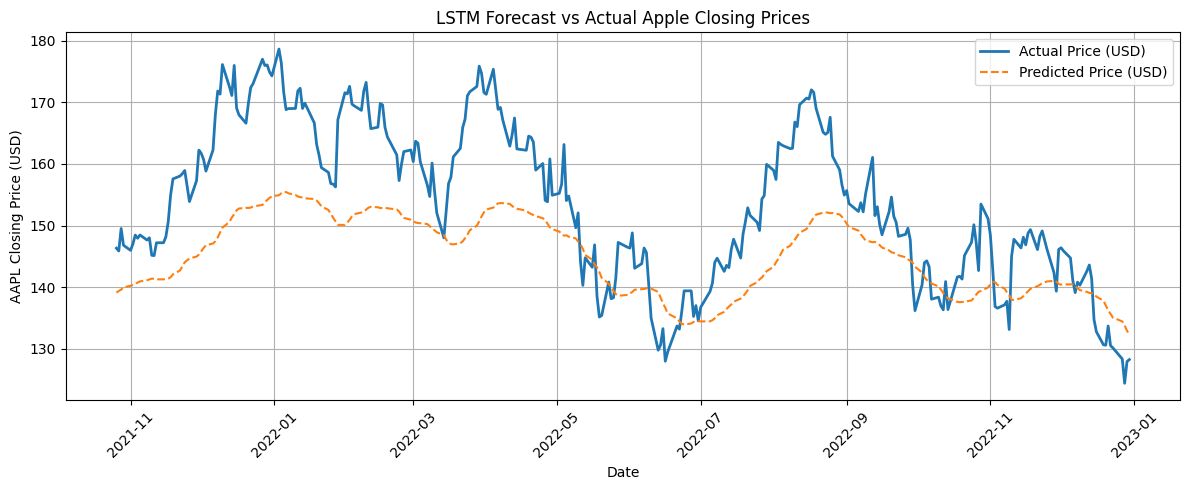

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --------- INVERSE TRANSFORM STEP ---------
# Assuming 'scaler' was used to normalize the 'Close' prices
# and both y_test and test_preds are in normalized form

pred_real = test_preds  # already inverse-transformed
actual_real = y_true    # already inverse-transformed

# --------- DATE INDEXING STEP (same as before) ---------
dates = close_prices.index
n_test = len(y_test)
start_idx = int((len(dates) - 30) * 0.85) + 30
test_dates = dates[start_idx:start_idx + n_test]

# --------- PLOT ACTUAL PRICES IN USD ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Price (USD)", linewidth=2)
plt.plot(test_dates, pred_real, label="Predicted Price (USD)", linestyle="--")
plt.title("LSTM Forecast vs Actual Apple Closing Prices")
plt.xlabel("Date")
plt.ylabel("AAPL Closing Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------- SAVE TO CSV ---------
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price (USD)": actual_real.flatten(),
    "LSTM Predicted Price (USD)": pred_real.flatten()
})

results_df.to_csv("lstm_forecast_vs_actual.csv", index=False)




# Gated Recurrent Unit Neural Network

<h1>GRU for Apple Stock Price Forecasting</h1>

GRU model:

- 2 GRU layers
- 64 hidden units
- Sequence length = 30
- MSE loss, Adam optimizer (learning rate = 0.001)
- Early stopping with patience = 10
- CPU execution



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------- Prepare data ----------------
X_train, y_train = X_train_stock, y_train_stock
X_val, y_val = X_val_stock, y_val_stock
X_test, y_test = X_test_stock, y_test_stock

# Reshape input: (samples, time_steps, features)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# ---------------- GRU Model ----------------
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])  # output at the final time step

model = GRUModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Stock-GRU):", mse)
print("Test MAE (Stock-GRU):", mae)
print("Test RMSE (Stock-GRU):", rmse)
print("Test MAPE (Stock-GRU):", mape, "%")


<h1>GRU Forecast vs Actual Apple Closing Price</h1>

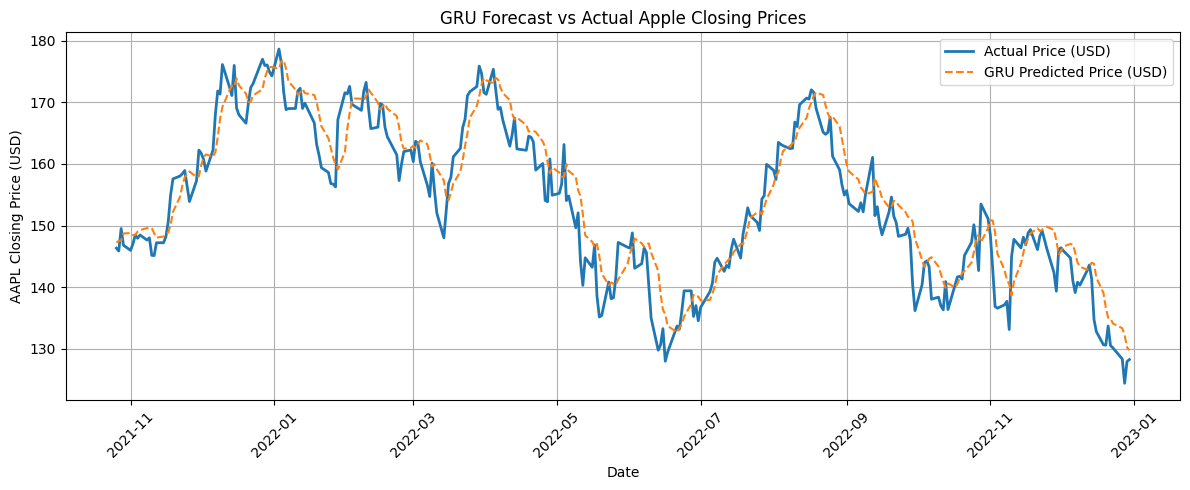

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --------- INVERSE TRANSFORM STEP ---------
# Assuming `scaler` is the same MinMaxScaler used to normalize the training data
# And `close_prices` is the full original DataFrame with 'Close' column

pred_real = test_preds  # already inverse-transformed
actual_real = y_true    # already inverse-transformed

# --------- DATE INDEXING STEP ---------
# close_prices.index contains the original datetime index from yfinance
dates = close_prices.index
n_test = len(y_test)

# Skip initial 30 days and start from 85% split point (as done during preprocessing)
start_idx = int((len(dates) - 30) * 0.85) + 30  # 30 is window size
test_dates = dates[start_idx:start_idx + n_test]

# --------- PLOT ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Price (USD)", linewidth=2)
plt.plot(test_dates, pred_real, label="GRU Predicted Price (USD)", linestyle="--")
plt.title("GRU Forecast vs Actual Apple Closing Prices")
plt.xlabel("Date")
plt.ylabel("AAPL Closing Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Create a DataFrame with Date, Actual Price, and Predicted Price
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price (USD)": actual_real.flatten(),
    "GRU Predicted Price (USD)": pred_real.flatten()
})

# Save to CSV
results_df.to_csv("gru_forecast_vs_actual.csv", index=False)



# Convolutional Neural Network

<h1>CNN for Apple Stock Price Forecasting</h1>

CNN Model:
- 1D convolutional layers with kernel sizes of 3 and 5
- Followed by a fully connected layer to output the prediction
- Input length = 30 (1D sequences)
- MSE loss, Adam optimizer, early stopping, CPU-only execution

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------- Prepare data ----------------
X_train, y_train = X_train_stock, y_train_stock
X_val, y_val = X_val_stock, y_val_stock
X_test, y_test = X_test_stock, y_test_stock

# Reshape input for CNN: (samples, channels=1, sequence_length)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ---------------- CNN Model ----------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

model = CNNModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()


# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)


# Metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Stock-CNN):", mse)
print("Test MAE (Stock-CNN):", mae)
print("Test RMSE (Stock-CNN):", rmse)
print("Test MAPE (Stock-CNN):", mape, "%")


<h1>CNN Forecast vs Actual Apple Closing Price</h1>

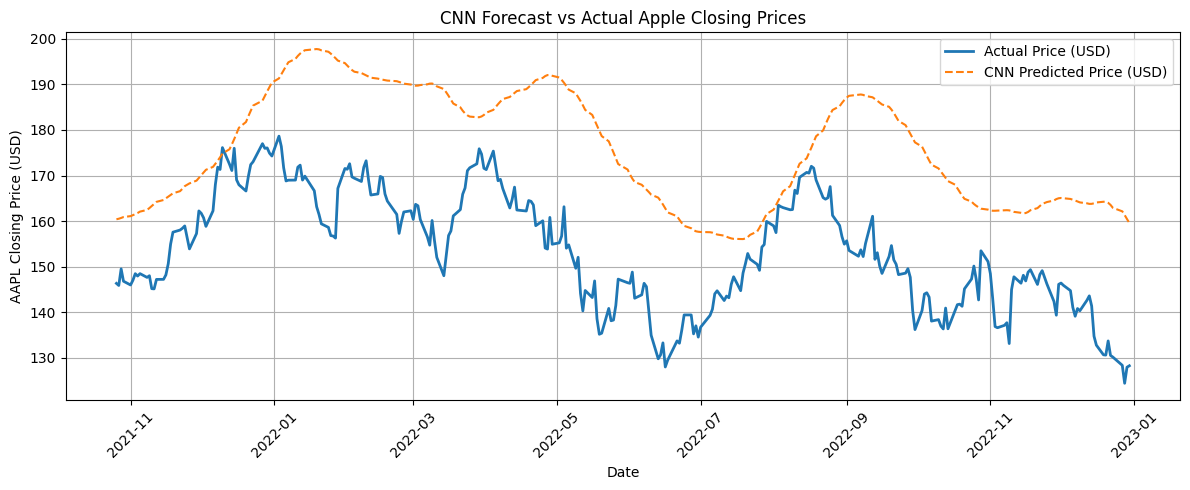

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

pred_real = test_preds  # already inverse-transformed
actual_real = y_true    # already inverse-transformed

# --------- DATE INDEXING STEP ---------
# Assuming close_prices is your full yfinance DataFrame
dates = close_prices.index
n_test = len(y_test)

# Match the test set's corresponding date range
start_idx = int((len(dates) - 30) * 0.85) + 30  # 30 = window size
test_dates = dates[start_idx:start_idx + n_test]

# --------- PLOT CNN RESULTS ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Price (USD)", linewidth=2)
plt.plot(test_dates, pred_real, label="CNN Predicted Price (USD)", linestyle="--")
plt.title("CNN Forecast vs Actual Apple Closing Prices")
plt.xlabel("Date")
plt.ylabel("AAPL Closing Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Create a DataFrame with Date, Actual Price, and Predicted Price
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price (USD)": actual_real.flatten(),
    "Predicted Price (USD)": pred_real.flatten()
})

# Save the DataFrame to a CSV file
results_df.to_csv("cnn_forecast_vs_actual.csv", index=False)


# Transformers

<h1>Transformer for Apple Stock Price Forecasting</h1>

Transformer Model:
- 2 encoder layers, 4 attention heads
- Feed-forward dimension = 128
- Input length = 30
- Includes positional encoding
- Trained using MSE loss, Adam optimizer, and early stopping

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

# ---------------- Prepare data ----------------
X_train, y_train = X_train_stock, y_train_stock
X_val, y_val = X_val_stock, y_val_stock
X_test, y_test = X_test_stock, y_test_stock

# Shape for Transformer: (sequence_length, batch_size, feature)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).transpose(0, 1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1).transpose(0, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).transpose(0, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# ---------------- Positional Encoding ----------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (i / d_model)))
                if i + 1 < d_model:
                    pe[pos, i + 1] = math.cos(pos / (10000 ** (i / d_model)))
        self.pe = pe.unsqueeze(1)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

# ---------------- Transformer Model ----------------
class TransformerModel(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = x[-1, :, :]  # use last time step's encoding
        return self.fc(out)

model = TransformerModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train.transpose(0, 1), y_train), batch_size=batch_size, shuffle=False)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        xb = xb.transpose(0, 1)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).detach()
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Stock-Transformer):", mse)
print("Test MAE (Stock-Transformer):", mae)
print("Test RMSE (Stock-Transformer):", rmse)
print("Test MAPE (Stock-Transformer):", mape, "%")


<h1>Transformer Forecast vs Actual Apple Closing Price</h1>

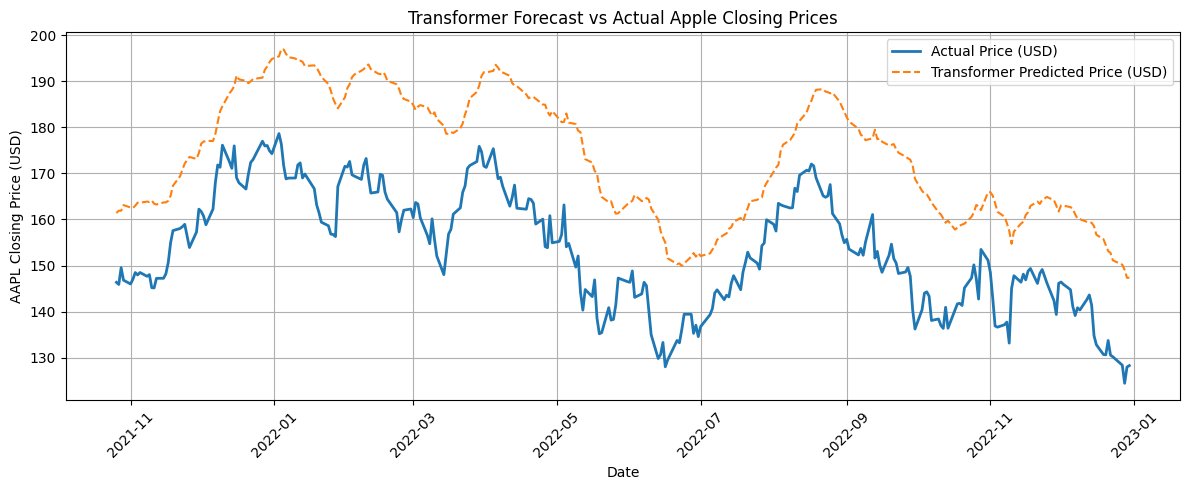

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Use already inverse-transformed predictions
pred_real = test_preds  # already inverse-transformed
actual_real = y_true    # already inverse-transformed

# --------- DATE INDEXING STEP ---------
dates = close_prices.index
n_test = len(actual_real)

start_idx = int((len(dates) - 30) * 0.85) + 30
test_dates = dates[start_idx:start_idx + n_test]

# --------- PLOT ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Price (USD)", linewidth=2)
plt.plot(test_dates, pred_real, label="Transformer Predicted Price (USD)", linestyle="--")
plt.title("Transformer Forecast vs Actual Apple Closing Prices")
plt.xlabel("Date")
plt.ylabel("AAPL Closing Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Create CSV
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price (USD)": actual_real.flatten(),
    "Predicted Price (USD)": pred_real.flatten()
})
comparison_df.to_csv("transformer_forecast_vs_actual.csv", index=False)


# Common Plots

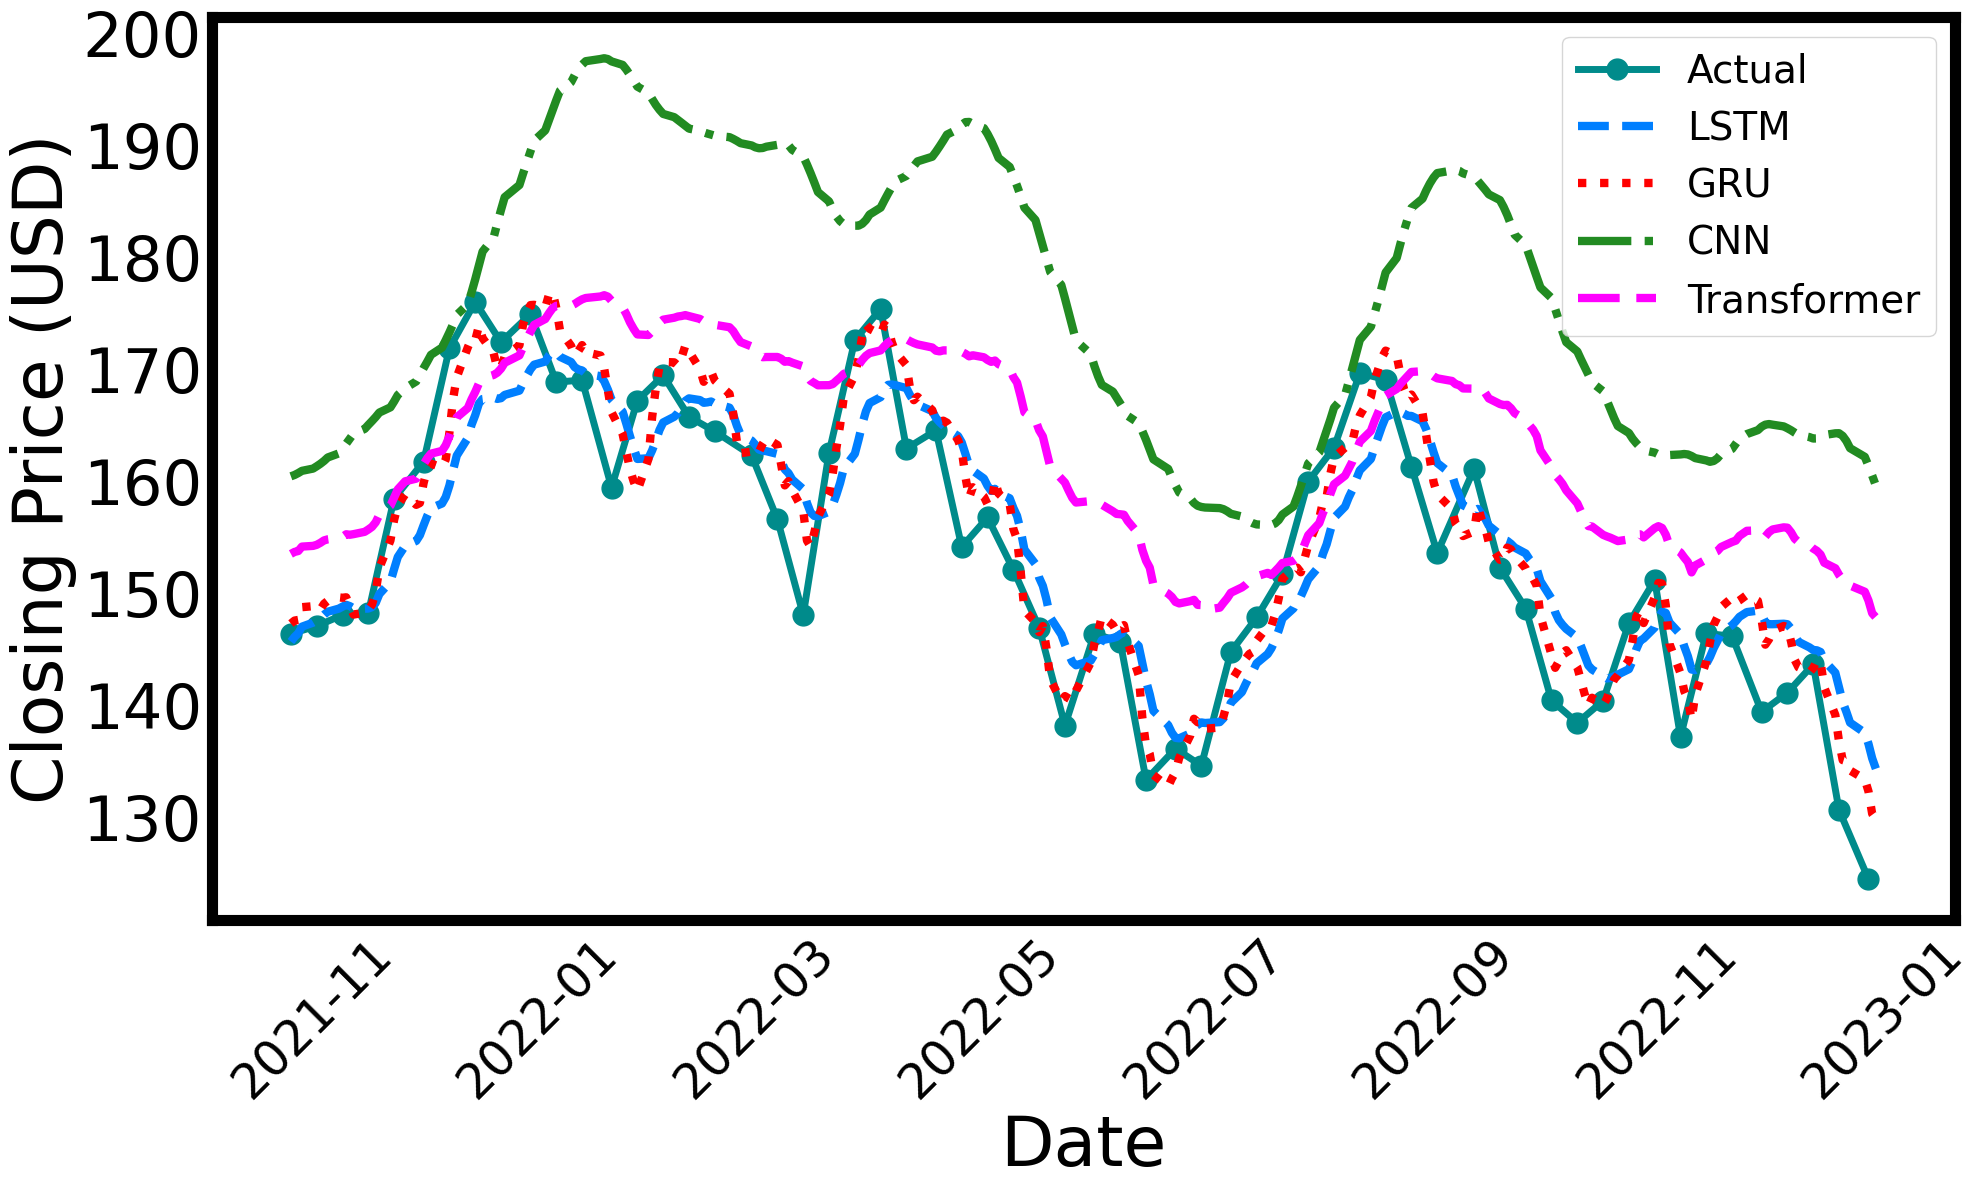

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --------- Load and rename columns ---------
df_lstm = pd.read_csv("lstm_forecast_vs_actual.csv")
df_gru = pd.read_csv("gru_forecast_vs_actual.csv")
df_cnn = pd.read_csv("cnn_forecast_vs_actual.csv")
df_trans = pd.read_csv("transformer_forecast_vs_actual.csv")

df_lstm.rename(columns={"Predicted Price (USD)": "LSTM Predicted Price (USD)"}, inplace=True)
df_gru.rename(columns={"Predicted Price (USD)": "GRU Predicted Price (USD)"}, inplace=True)
df_cnn.rename(columns={"Predicted Price (USD)": "CNN Predicted Price (USD)"}, inplace=True)
df_trans.rename(columns={"Predicted Price (USD)": "Transformer Predicted Price (USD)"}, inplace=True)

# Convert date columns
for df in [df_lstm, df_gru, df_cnn, df_trans]:
    df["Date"] = pd.to_datetime(df["Date"])

# --------- Prepare for Plot ---------
dates = df_lstm["Date"]
actual = df_lstm["Actual Price (USD)"]

# Downsample actual values for visibility
step = 5
dates_sparse = dates[::step]
actual_sparse = actual[::step]

# --------- Plot ---------
plt.figure(figsize=(20, 12))

# Actual values (sparser, with markers)
plt.plot(dates_sparse, actual_sparse, label="Actual", color="#008B8B", linestyle='solid',
         linewidth=5, marker='o', markersize=15)

# Predictions (full)
plt.plot(dates, df_lstm["LSTM Predicted Price (USD)"], label="LSTM", color="#007FFF", linestyle='--', linewidth=6)
plt.plot(dates, df_gru["GRU Predicted Price (USD)"], label="GRU", color="red", linestyle=':', linewidth=6)
plt.plot(dates, df_cnn["CNN Predicted Price (USD)"], label="CNN", color="forestgreen", linestyle='-.', linewidth=6)
plt.plot(dates, df_trans["Transformer Predicted Price (USD)"], label="Transformer", color="magenta",
         linestyle=(0, (5, 2)), linewidth=6)

# Axis labels
plt.xlabel("Date", fontsize=50)
plt.ylabel("Closing Price (USD)", fontsize=50)
plt.xticks(rotation=45, fontsize=35)
plt.yticks(fontsize=45)

# Remove grid
plt.grid(False)

# Thicken plot border
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(8)

# Legend
plt.legend(fontsize=28)

# Layout and Save
plt.tight_layout()
# Uncomment to save:
plt.savefig("forecast_comparison_improved.png", dpi=300)
plt.show()
